# 淘宝用户行为分析

## 背景介绍

    淘宝网是中国深受欢迎的网购零售平台，拥有近5亿的注册用户数，每天有超过6000万的固定访客，同时每天的在线商品数已经超过了8亿件，平均每分钟售出4.8万件商品。 用户行为分析则是电商平台的重要事务，通过对用户行为的分析，有助于企业根据用户的行为习惯，找出网站、推广渠道等企业营销环境存在的问题，从而让企业的营销更加精准、有效，提升企业的广告收益。
    本次报告随机采集了在2017年11月25日至2017年12月3日之间，淘宝用户的行为，其中行为包括浏览、加购物车、收藏、购买等。数据集主要包含：用户数量约100万（987,994），商品数量约400万（4,162,024），商品类目数量9439,以及总的淘宝用户行为记录数量约1亿条（100,150,807）。 
数据来源：https://tianchi.aliyun.com/dataset/dataDetail?dataId=649&userId=1 

字段含义：
    
    UserID	        整数类型，序列化后的用户ID
    ItemID	        整数类型，序列化后的商品ID
    CategoryID	    整数类型，序列化后的商品所属类目ID
    BehaviorType	字符串，枚举类型，包括('pv', 'buy', 'cart', 'fav')
    TimeStamp	    行为发生的时间戳

其中，用户行为类型共有四种，它们分别是：
    
    行为类型	说明
    pv	       商品详情页pv，等价于点击
    buy        商品购买
    cart	   将商品加入购物车
    fav	       收藏商品
    
    分析思路：

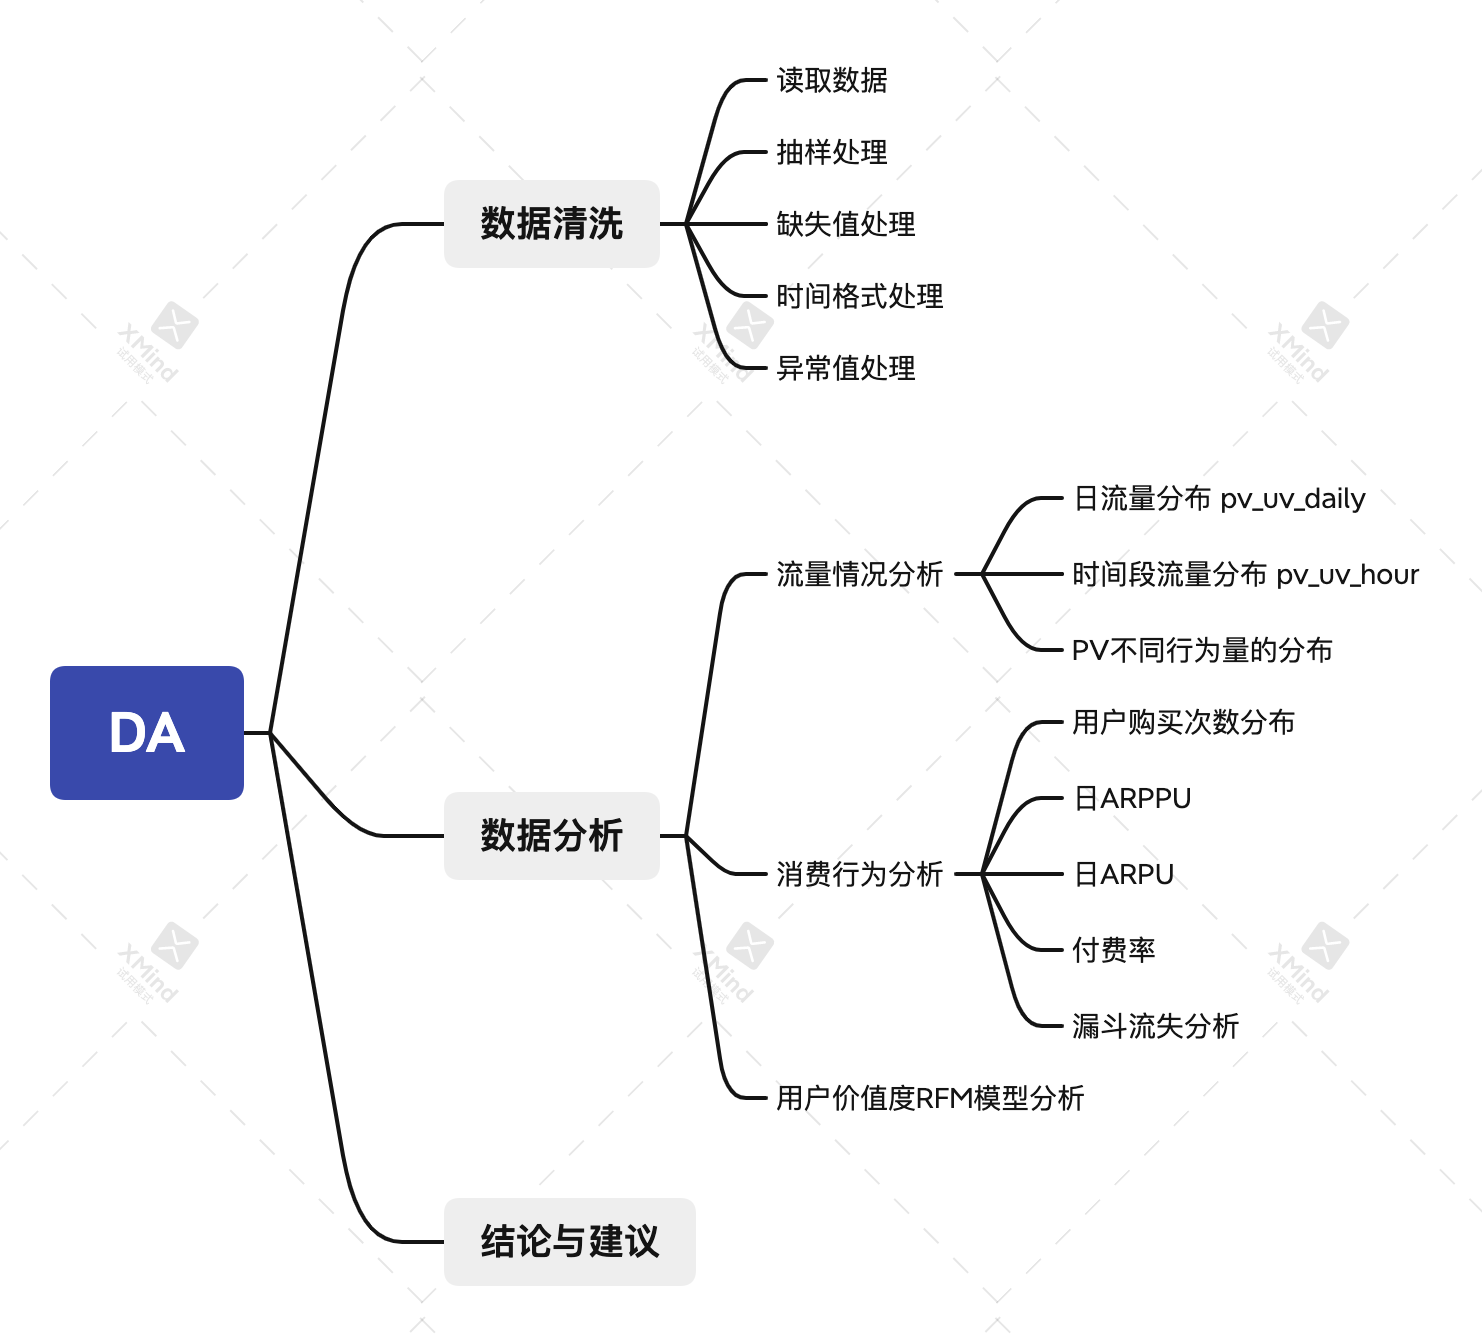

## 数据清洗

In [1]:
#数据导入
#引入必要的库
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

#设置参数
sns.set(style='darkgrid',font_scale=1.5)
plt.rcParams['font.family']='Arial Unicode MS'
plt.rcParams['axes.unicode_minus']=False

#读取文件（文件过大，设置断点，分块读取）
f = open('/Users/moxiaoqian/Desktop/UserBehavior.csv')
reader = pd.read_csv(f, sep=',', iterator=True,
                     header=None,names=['UserId','ItemId','CategoryId','BehaviorType','TimeStamp'])   #增加表头信息
loop = True
chunkSize = 100000
chunks = []
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        chunks.append(chunk)
    except StopIteration:
        loop = False
        print("Iteration is stopped.")
df = pd.concat(chunks, ignore_index=True)
df.head()   #预览

Iteration is stopped.


,UserId,ItemId,CategoryId,BehaviorType,TimeStamp
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146


In [2]:
#查看字段唯一值数量
def check_unique(data):
    for column in data.columns:
        print('{}唯一值数量:'.format(column),len(data[column].unique()))

#查看df原表字段情况
check_unique(df)

UserId唯一值数量: 987994
ItemId唯一值数量: 4162024
CategoryId唯一值数量: 9439
BehaviorType唯一值数量: 4
TimeStamp唯一值数量: 815859


In [3]:
df['BehaviorType'].count()

100150807

In [4]:
#抽样
#数据量过大，以1%的比例对源数据进行随机抽样
data= df.sample(frac=0.01,random_state=1,replace=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001508 entries, 37662562 to 99147242
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   UserId        1001508 non-null  int64 
 1   ItemId        1001508 non-null  int64 
 2   CategoryId    1001508 non-null  int64 
 3   BehaviorType  1001508 non-null  object
 4   TimeStamp     1001508 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 45.8+ MB


In [5]:
#缺失值处理
data.apply(lambda x: sum(x.isnull()))

UserId          0
ItemId          0
CategoryId      0
BehaviorType    0
TimeStamp       0
dtype: int64

In [6]:
#异常值处理
#原始数据日期区间为2017-11-25到2017-12-03，这个时间区间外认为是异常数据。

def get_unixtime(timeStr):
    formatStr = "%Y-%m-%d %H:%M:%S"
    tmObject = time.strptime(timeStr, formatStr)
    tmStamp = time.mktime(tmObject)
        
    return int(tmStamp)
    
# 剔除给定区间外的时间
startTime = get_unixtime("2017-11-25 00:00:00")
endTime = get_unixtime("2017-12-3 23:59:59")
data['TimeStamp'] = data['TimeStamp'].astype('int64')
data= data.loc[(data['TimeStamp'] >= startTime) & (data['TimeStamp'] <= endTime)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000975 entries, 37662562 to 99147242
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   UserId        1000975 non-null  int64 
 1   ItemId        1000975 non-null  int64 
 2   CategoryId    1000975 non-null  int64 
 3   BehaviorType  1000975 non-null  object
 4   TimeStamp     1000975 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 45.8+ MB


In [7]:
#时间格式处理
data.loc[:,'TimeStamp']=data['TimeStamp'].apply(lambda x:time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(x)))
data.loc[:,'Date']=data['TimeStamp'].apply(lambda x:x.split(' ')[0])  #日期列
data.loc[:,'Time']=data['TimeStamp'].apply(lambda x:x.split(' ')[1])  #时间列
data['Date']=pd.to_datetime(data['Date'])  #将Date列，由str转换为时间格式
data['Time']=pd.to_datetime(data['Time'])  #将Time列，由str转换为时间格式
data['Hour']=data['Time'].dt.hour   #提取小时列
data=data.drop(['TimeStamp','Time'],axis=1)   #删除时间戳、时间列
data.head()

,UserId,ItemId,CategoryId,BehaviorType,Date,Hour
37662562,896242,4700974,4558987,pv,2017-11-30,8
58888083,950299,3074368,4801426,pv,2017-11-26,7
44574723,295390,4855638,2304296,pv,2017-11-29,8
62337373,191153,4871216,4217906,pv,2017-11-26,10
97515924,880860,4000480,1029459,pv,2017-11-25,20


In [8]:
check_unique(data)

UserId唯一值数量: 528581
ItemId唯一值数量: 480588
CategoryId唯一值数量: 6443
BehaviorType唯一值数量: 4
Date唯一值数量: 9
Hour唯一值数量: 24


## 数据分析

### 流量情况分析

#### 日流量分布 pv_uv_daily

Text(0.5, 1.0, 'UV日访客量分布')

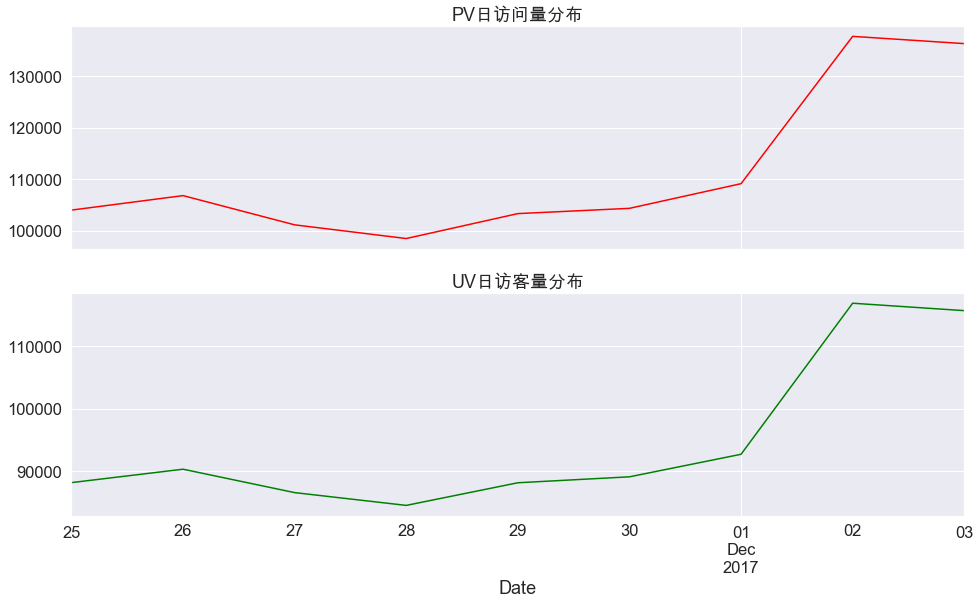

In [20]:
pv_daily=data.groupby('Date').count()['UserId']   #日访问量
uv_daily=data.groupby('Date')['UserId'].apply(lambda x: x.drop_duplicates().count())   #日访客量
pv_uv_daily=pd.concat([pv_daily,uv_daily],axis=1)
pv_uv_daily.columns=['PV','UV']

fig,axes=plt.subplots(2,1,sharex=True)
fig.set_size_inches(16,9)
pv_daily.plot.line(x='Date',y='PV',color='red',ax=axes[0])
uv_daily.plot.line(x='Date',y='UV',color='green',ax=axes[1])
axes[0].set_title('PV日访问量分布')
axes[1].set_title('UV日访客量分布')

    可以发现，PV与UV的每日变化趋势大致相同：工作日维持在低值，其中周二（11-27）的访问量达到统计范围内最低值；而11月25日、11月26日和12月2日、12月3日同为周末，但后者却有更多的活跃用户，环比增长率约为32%，推测可能是平台做促销活动。检索可知正值“双十二”前夕，各类预热活动促进用户访问增长。·m

#### 时间段流量分布 pv_uv_hour

Text(0.5, 1.0, 'uv小时访客量分布')

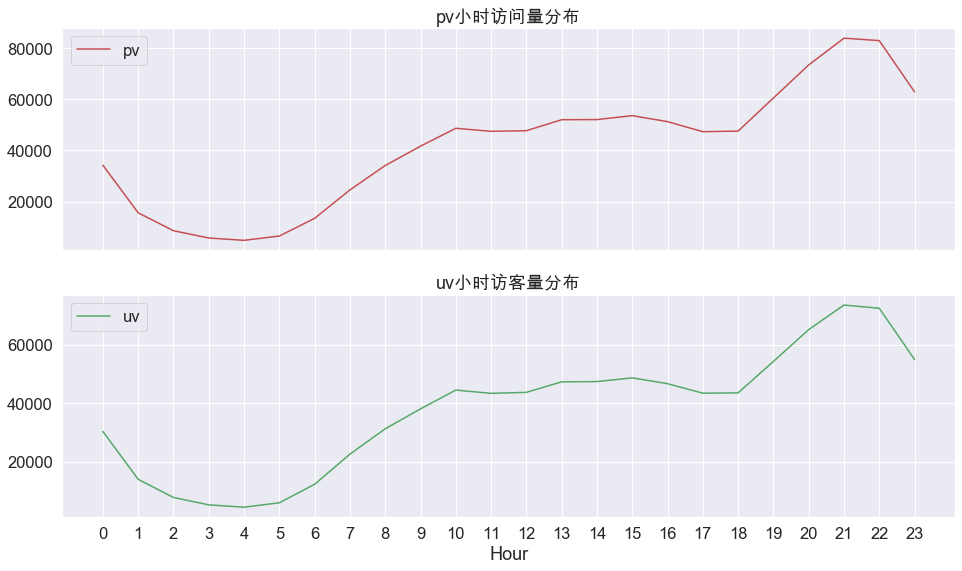

In [12]:
pv_hour=data.groupby('Hour')['UserId'].count().reset_index().rename(columns={'UserId':'pv'})
uv_hour=data.groupby('Hour')['UserId'].apply(lambda x:x.drop_duplicates().count()).reset_index().rename(columns={'UserId':'uv'})
fig,axes=plt.subplots(2,1,sharex=True)
fig.set_size_inches(16,9)
pv_hour.plot.line(x='Hour',y='pv',ax=axes[0],color='r')
uv_hour.plot.line(x='Hour',y='uv',ax=axes[1],color='g')
plt.xticks(range(0,24))
axes[0].set_title('pv小时访问量分布')
axes[1].set_title('uv小时访客量分布')

    流量的时间段分布基本符合人们的作息规律：0点至6点是休息时间，点击量处于低谷阶段；6点至10点，人们慢慢开始工作，点击量开始回暖；10点至18点为正常工作时间，点击量保持平稳；18点至20点，人们相继下班休息，点击量不断升高；在21点至22点期间，点击量到达高峰。

#### PV不同行为量的分布

Text(0.5, 1.0, 'PV不同行为量的分布（剔除点击行为）')

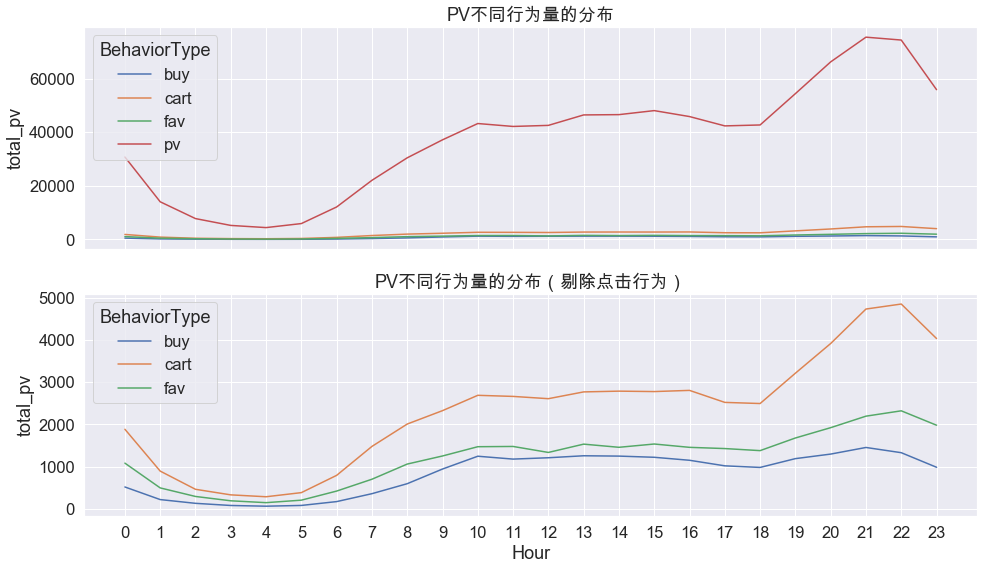

In [16]:
pv_detail=data.groupby(['BehaviorType','Hour'])['UserId'].count().reset_index().rename(columns={'UserId':'total_pv'})

fig,axes=plt.subplots(2,1,sharex=True)
fig.set_size_inches(16,9)
sns.lineplot(x='Hour',y='total_pv',hue='BehaviorType',data=pv_detail,ax=axes[0])
sns.lineplot(x='Hour',y='total_pv',hue='BehaviorType',data=pv_detail[pv_detail['BehaviorType']!='pv'],ax=axes[1])
plt.xticks(range(0,24))
axes[0].set_title('PV不同行为量的分布')
axes[1].set_title('PV不同行为量的分布（剔除点击行为）')

    可以看出，四种行为随时间的波动基本一致，点击行为远高于其他三种行为量。18点到22点是行为量的高峰。此外，加入购物车的量普遍比收藏量都大，所以后面漏斗分析可以把加入购物车作为收藏商品的前一步骤。

### 用户消费行为分析

#### 用户购买次数分布

In [17]:
data_buy=data[data.BehaviorType=='buy'].groupby('UserId')['BehaviorType'].count()
data_buy.describe()

count    19399.000000
mean         1.024640
std          0.159295
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: BehaviorType, dtype: float64

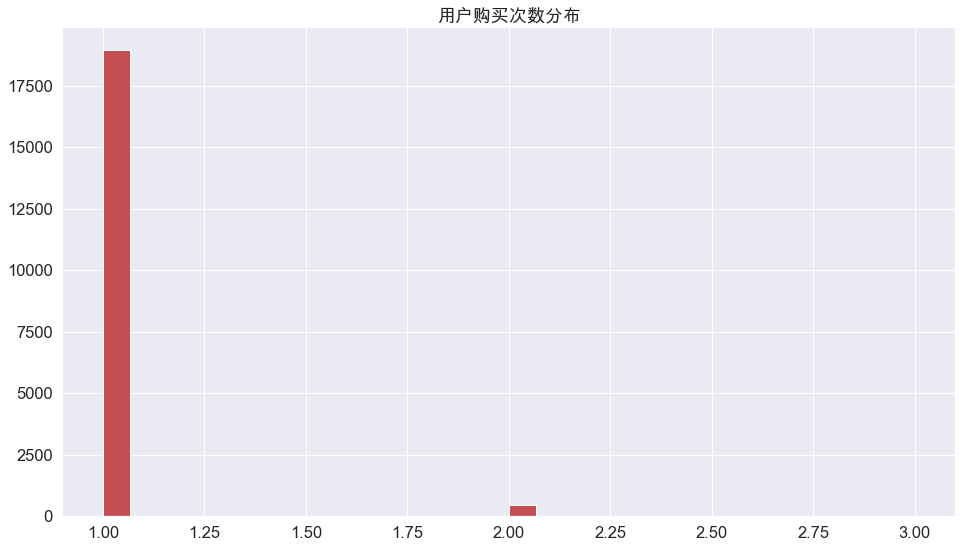

In [18]:
plt.figure(figsize=(16,9))
plt.hist(x=data_buy,bins=30,color='r')
plt.title('用户购买次数分布')
plt.show()

    可以看出普遍消费次数都是1次。所以对于购买1次以上的可以作为重点用户进行关注。

#### 日ARPPU

*每付费用户平均收益Average Revenue Per Paying User
 由于数据没有消费金额，因此用消费频率代替金额以做研究
人均消费次数=消费总次数/消费用户人数

Text(0.5, 1.0, '日ARPPU情况')

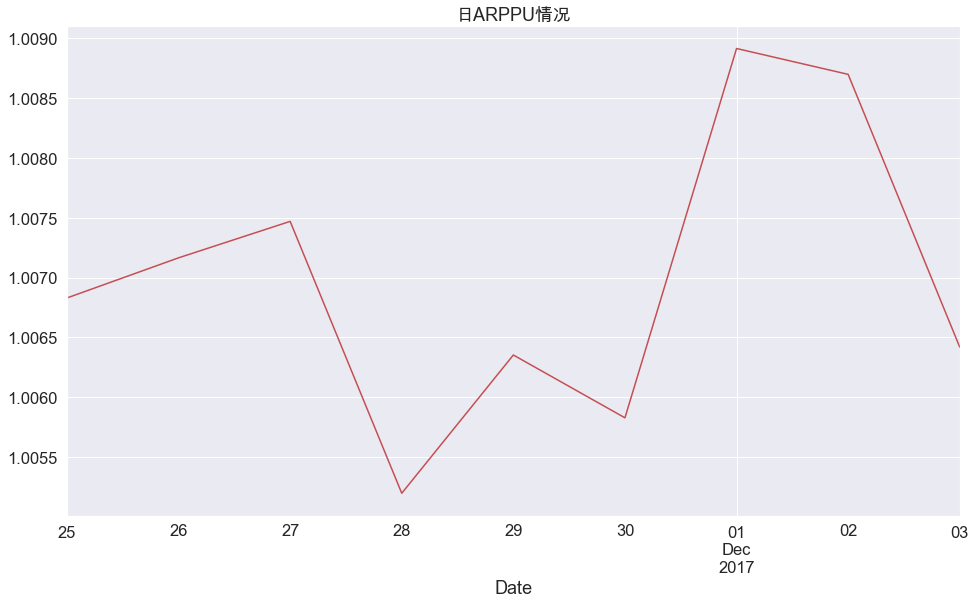

In [19]:
data['operation']=1
plt.figure(figsize=(16,9))
data_buy1=data[data.BehaviorType=='buy'].groupby(['Date','UserId'])['BehaviorType'].count().reset_index().rename(columns={'BehaviorType':'total'})
data_buy2=data_buy1.groupby('Date').sum()['total']/data_buy1.groupby('Date').count()['total']
data_buy2.plot(color='r')
plt.title('日ARPPU情况')

    由图像可以看出，在11月28日的日ARPPU为最低位.

#### 日ARPU

In [ ]:
*每活跃用户数平均收益Average Revenue Per User
 由于数据没有消费金额，因此用消费频率代替金额以做研究
 每活跃用户数平均消费次数=消费总次数/活跃用户人数(每天有操作行为的为活跃)

Text(0.5, 1.0, '日ARPU情况')

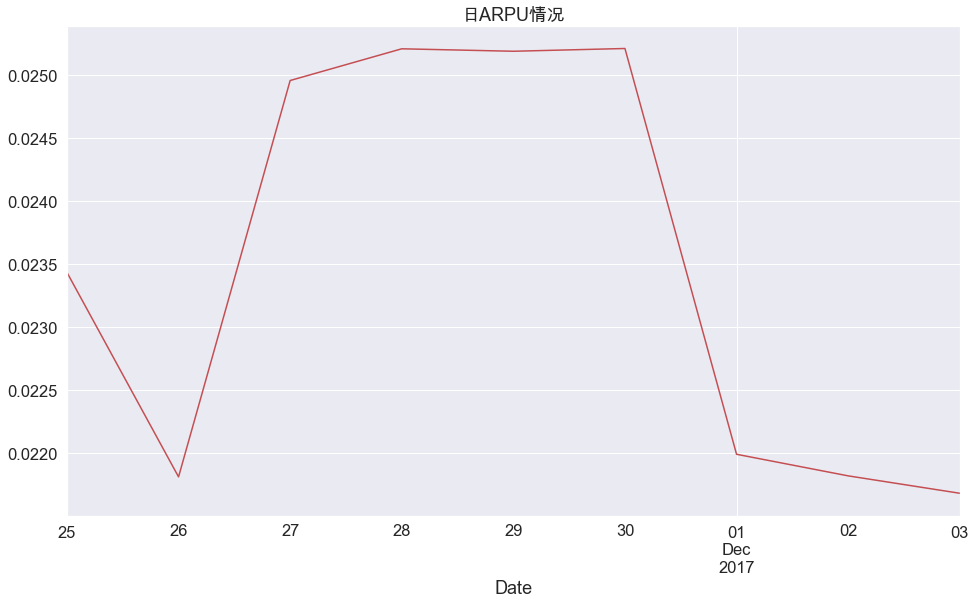

In [21]:
plt.figure(figsize=(16,9))
data_buy3=data.groupby(['Date','UserId','BehaviorType'])['operation'].count().reset_index().rename(columns={'operation':'total'})
data_buy3.groupby('Date').apply(lambda x:x[x.BehaviorType=='buy'].total.sum()/len(x.UserId.unique())).plot(color='r')
plt.title('日ARPU情况')

    可以看出，工作日活跃用户平均消费次数为0.025左右次，休息日活跃用户平均消费次数更低，为0.022左右次.

#### 漏斗流失分析

In [22]:
data_count=data.groupby('BehaviorType').size()
data_count

BehaviorType
buy      19877
cart     55743
fav      28992
pv      896363
dtype: int64

In [26]:
from pyecharts import options as opts
from pyecharts.charts import Funnel
from pyecharts.faker import Faker

attr = ['pv 896363', 'cart 55743', 'fav 28992', 'buy 19877']
value = [896363, 55743, 28992, 19877] 
funnel = Funnel()
funnel.add("漏斗分析", [list(z) for z in zip(attr,value)])
funnel.set_global_opts(title_opts=opts.TitleOpts(title="漏斗分析"))
funnel.render("funnel_base.html") 
funnel.render_notebook()

In [32]:
pv_cart=(data_count['pv']-data_count['cart'])/data_count['pv']
cart_fav=(data_count['cart']-data_count['fav'])/data_count['cart']
fav_buy=(data_count['fav']-data_count['buy'])/data_count['fav']
pv_buy=(data_count['pv']-data_count['buy'])/data_count['pv']
Loss=pd.DataFrame([['pv_to_cart',pv_cart],
                  ['cart_to_fav',cart_fav],
                  ['fav_to_buy',fav_buy],
                  ['pv_to_buy',pv_buy]],
                 columns=['项目','流失率'])
print(Loss)

            项目       流失率
0   pv_to_cart  0.937812
1  cart_to_fav  0.479899
2   fav_to_buy  0.314397
3    pv_to_buy  0.977825


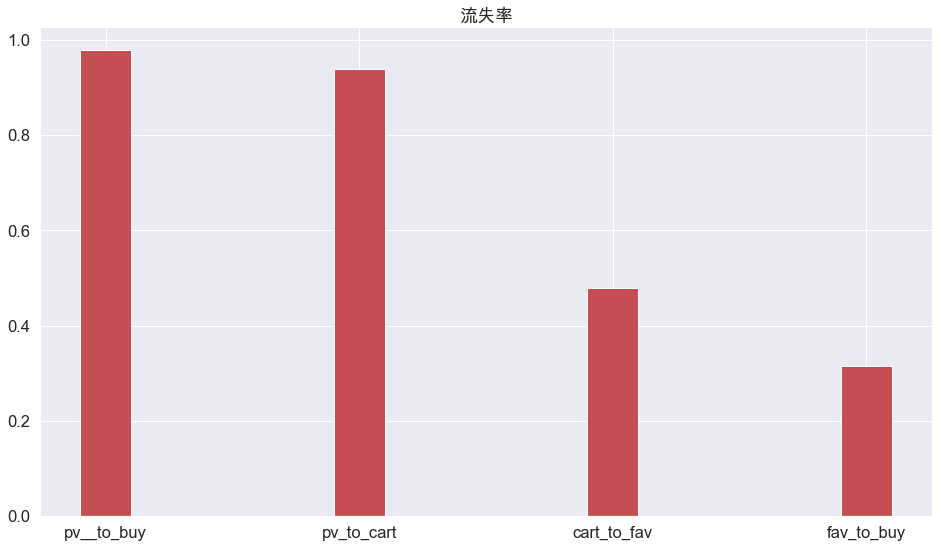

In [24]:
plt.figure(figsize=(16,9))
x=['pv_to_buy','pv_to_cart','cart_to_fav','fav_to_buy']
loss=[pv_buy,pv_cart,cart_fav,fav_buy]
plt.bar(x,loss,width=0.2,color='r')
plt.title('流失率')
plt.show()

    从点击到购买的全过程中，流失率主要集中在点击到加入购物车这一环节，流失率高达93.78%，收藏及加入购物车后购买商品的可能性增大。

### 用户价值度RFM模型分析

In [27]:
from datetime import datetime
datetime(2017,12,4)
recent=data[data['BehaviorType']=='buy'].groupby('UserId')['Date'].apply(lambda x: datetime(2017,12,4) -(data['Date'].max())).reset_index().rename(columns={'Date':'recent'})
recent.recent=recent.recent.map(lambda x:x.days)   #仅保留数字值
freq=data[data['BehaviorType']=='buy'].groupby('UserId')['Date'].count().reset_index().rename(columns={'Date':'freq'})
rfm=pd.merge(recent,freq,left_on='UserId',right_on='UserId',how='outer')
rfm.head()

,UserId,recent,freq
0,136,1,1
1,164,1,1
2,190,1,1
3,223,1,1
4,276,1,1


In [28]:
#将R、F分别划分为1、2、3三个等级，数值组合越大，用户价值度越高
rfm['recent_value']=pd.cut(rfm.recent,3,labels=['3','2','1'],duplicates='drop')
rfm['freq_value']=pd.cut(rfm.freq,3,labels=['1','2','3'],duplicates='drop')
rfm['rfm']=rfm['recent_value'].str.cat(rfm['freq_value'])
rfm.head()

,UserId,recent,freq,recent_value,freq_value,rfm
0,136,1,1,2,1,21
1,164,1,1,2,1,21
2,190,1,1,2,1,21
3,223,1,1,2,1,21
4,276,1,1,2,1,21


In [29]:
rfm1=rfm.groupby('rfm').size()
rfm1

rfm
21    18934
22      452
23       13
dtype: int64

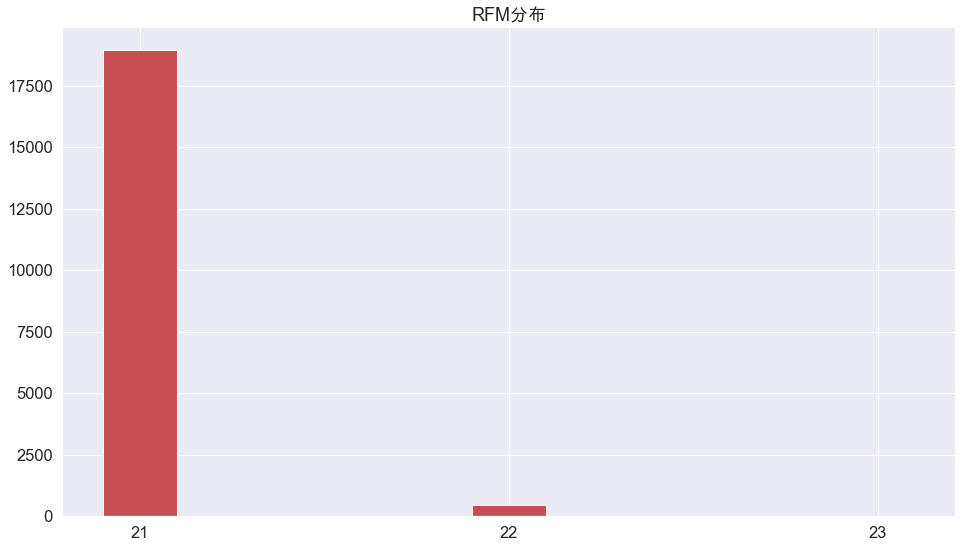

In [30]:
plt.figure(figsize=(16,9))
x=['21','22','23']
loss=[rfm1['21'],rfm1['22'],rfm1['23']]
plt.bar(x,loss,width=0.2,color='r')
plt.title('RFM分布')
plt.show()

    由于数据没有金额所以缺少消费金额（m）这一列，通过打分可以了解每位顾客的特性，从而实现差异化营销。比如对于23用户，为重点用户需要关注；对于21这类忠诚度高而购买能力不足的，可以可以适当给点折扣或捆绑销售来增加用户的购买频率。

## 结论与建议

1.通过对流量情况的分析，可以发现pv,uv随着时间呈现周期性变化，并且一天中不同时间段用户活跃度也不同，因此在做商品推广和广告营销尽量选择活跃度比较高的时间段会有更好效果。

3.通过对用户消费行为的分析，可以发现用户消费的时间段规律以及用户流失的情况，在这些时间段进行相应的商品推荐效果更优。

4.通过对用户的RFM模型分析，可以有效对不同用户进行不同群体划分，不同群体采用不同的个性化营销手段，能产生更好的效益。